<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%B1%D0%B5%D0%B7_%D1%81%D0%BA%D1%80%D1%8B%D1%82%D0%BE%D0%B3%D0%BE_%D1%81%D0%BB%D0%BE%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 4.1MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533284 sha256=2bf2f8068932ebd8d28c36240030bb6d7678dac1891a42377fda8b4b97a7c9e2
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=c5fe6dca1ccf7ded1fcab49230d6ab2c84839388ce487c9f4ccae014f4cfc139
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-x2fpnazy
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-x2fpnazy
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=8f3e839a51587b2d1ec2afe9068871a8ff4d127411c5984e71f3896dfa6ea7f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdl3lzyd/wheels/9c/7a/cc/d1ffa9ccaa42b

In [2]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

from sklearn.preprocessing import StandardScaler 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_bss_27.11.2020.pkl'

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Загрузка истории

In [3]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.539882,4.496876,10.840267,6.937616
2010-01-05,6.551187,5.005957,10.896401,7.396526
2010-01-06,6.446983,4.798555,10.840267,7.673220
2010-01-07,6.435065,4.939965,11.401575,7.868933
2010-01-08,6.477847,4.845690,11.647147,7.889179
...,...,...,...,...
2020-11-20,117.339996,12.530000,9.760000,8.740000
2020-11-23,113.849998,13.560000,10.070000,8.860000
2020-11-24,115.169998,14.820000,10.450000,9.450000


# Алгоритм распределения

In [4]:
def predWeights(d,
                lookback=10,        # окно
                learnLen=300,       # глубина обучения
                reg = 0.0001,       # коэффициент регуляризации
                min_delta = 0.001,  # дельта
                lr=0.001,           # скорость обучения
                ansmbl=5            # размер ансамбля
                ):

    n = d.shape[1]
    
    X = pd.concat([d.shift(1+n) for n in range(1,lookback+1)],axis=1)  # собираем входы в гусеницу
    y = d                                                              # считаем выход на обучении 
    xy = pd.concat([y,X],axis=1).dropna()                              # сцепляем выход и входы. Убираем не числа
    y = xy.iloc[-learnLen:,:n]                                         # вырезаем выход
    X = xy.iloc[-learnLen:,n:]                                         # вырезаем входы
    
    ss_model = StandardScaler().fit(X)                                 # входное нормированеи учим

    # функция потерь
    
    def loss_function(y_true, y_pred):
        # return tf.nn.relu(tf.math.reduce_mean(y_true,axis=1))-tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1) # с отрывом от равновесной стратегии
        return -tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    X_learn = ss_model.transform(X)
    X_pred = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    X_pred = ss_model.transform(X_pred)

    # raise Exception(y.std(axis=0))

    wts = []

    for _ in range(ansmbl):

        model = keras.Sequential([layers.Dense(n+1,
                                            input_shape=(X.shape[1],),
                                            activation='softmax',
                                            kernel_regularizer=keras.regularizers.l2(reg))])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=loss_function)
        
        learn_res = model.fit(X_learn, y, 
                            epochs=200,
                            validation_split=0.2,
                            verbose=False,
                            use_multiprocessing=True,
                            callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10,verbose=0)])
        
        weights = model.predict(X_pred)[-1,:-1]

        wts.append(weights)

    return np.mean(wts,axis=0)

dData = data.to_returns()
t=1000

wts = []

for n in range(10):
    weights = predWeights(dData[:t],ansmbl=10)
    wts.append(weights)
    print(weights,1-sum(weights))

wts = np.array(wts)

print('---------------')
print(wts.mean(axis=0))                 # среднее
print(np.quantile(wts,q=0.5,axis=0))    # половинный квантиль

[0.18938188 0.19069466 0.1824059  0.31337008] 0.12414747476577759
[0.13844582 0.20570426 0.15787253 0.326238  ] 0.1717393845319748
[0.31138176 0.16655476 0.22967689 0.2370243 ] 0.0553622841835022
[0.1038651  0.21103573 0.179747   0.38333184] 0.12202033400535583
[0.25156388 0.19491293 0.1259965  0.3176206 ] 0.10990609228610992
[0.10025047 0.28768188 0.08789799 0.33620209] 0.18796758353710175
[0.22155634 0.34962505 0.11097129 0.21334004] 0.10450728237628937
[0.1627123  0.32243267 0.11961837 0.22818923] 0.1670474261045456
[0.12570637 0.2340575  0.24632129 0.23452179] 0.1593930423259735
[0.19348976 0.15487763 0.25451592 0.07696445] 0.32015224546194077
---------------
[0.17983536 0.23175772 0.16950238 0.26668024]
[0.17604709 0.20836999 0.16880976 0.27519719]


In [5]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        
    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        weights = predWeights(d,
                                lookback=self.lookback,
                                learnLen=self.learnLen,
                                reg=np.power(10,self.reg),
                                min_delta=np.power(10,self.min_delta),
                                lr=np.power(10,self.lr),
                                ansmbl=1)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [6]:
# %%time
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,lenRisk):

    t = np.random.randint(2+learnLen+max(lookback,lenRisk)+1,lenData-1-2)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          ansmbl=1)
    #print(t)
    d = dData.iloc[t+1].values
    covar = np.cov(dData[t-lenRisk:].values,rowvar=False)
    
    D = lambda x: np.dot(d,x)
    R = lambda x: np.dot(np.dot(covar,x),x)
    kSharp = lambda x: D(x) / np.sqrt(R(x))

    weights_r = np.ones_like(weights) / covar.shape[0]

    return kSharp(weights) - kSharp(weights_r)

getQualityMethod(200,130,0.001,0.001,0.01,100)

0.07978027905313936

## Создание модели

In [7]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,300),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      lenRisk=range(2,200),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [18]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  5948 {'quality': -0.4923359294707754, 'lookback': 49, 'learnLen': 404, 'reg': -3.3700000000000774, 'min_delta': -5.730000000000027, 'lr': -0.29000000000014303, 'lenRisk': 158}
finish -  5958 {'quality': -0.045097571017986726, 'lookback': 72, 'learnLen': 297, 'reg': -2.540000000000095, 'min_delta': -6.760000000000005, 'lr': -1.1000000000001258, 'lenRisk': 144}
finish -  5968 {'quality': 0.12409926378961122, 'lookback': 56, 'learnLen': 295, 'reg': -3.1700000000000816, 'min_delta': -6.480000000000011, 'lr': -0.7700000000001328, 'lenRisk': 165}
finish -  5978 {'quality': -0.0006206765844832818, 'lookback': 40, 'learnLen': 302, 'reg': -2.8000000000000895, 'min_delta': -5.550000000000031, 'lr': -0.6100000000001362, 'lenRisk': 155}
finish -  5988 {'quality': 0.3042913643181664, 'lookback': 46, 'learnLen': 376, 'reg': -3.1300000000000825, 'min_delta': -5.470000000000033, 'lr': -0.11000000000014687, 'lenRisk': 170}
finish -  5998 {'quality': -0.3611136929395406, 'lookback': 53, 'learn

KeyboardInterrupt: ignored

## Графики

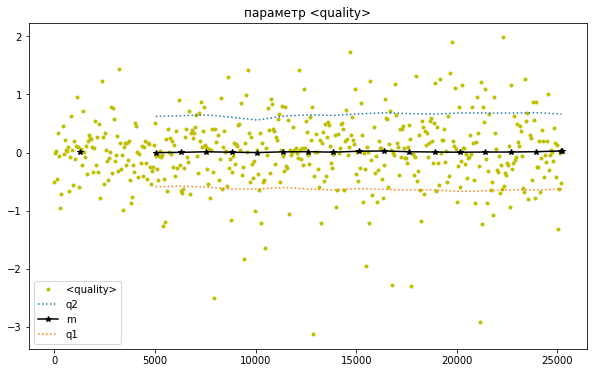

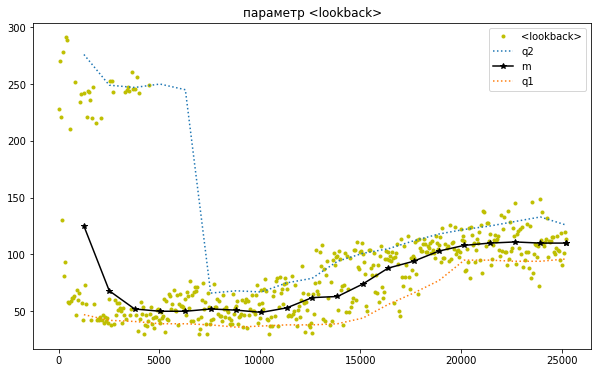

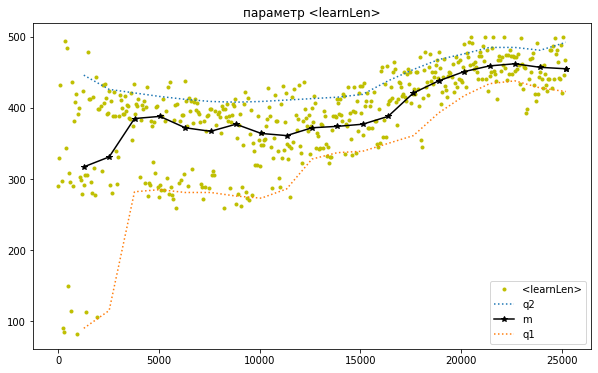

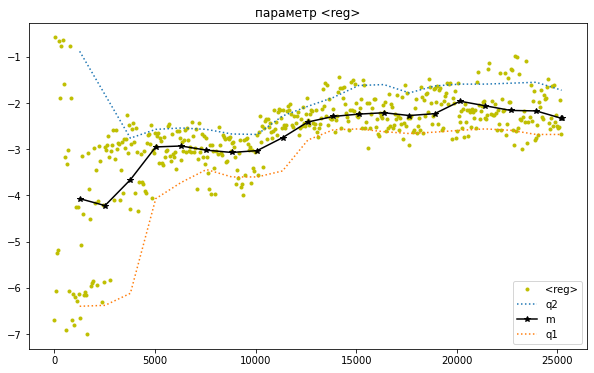

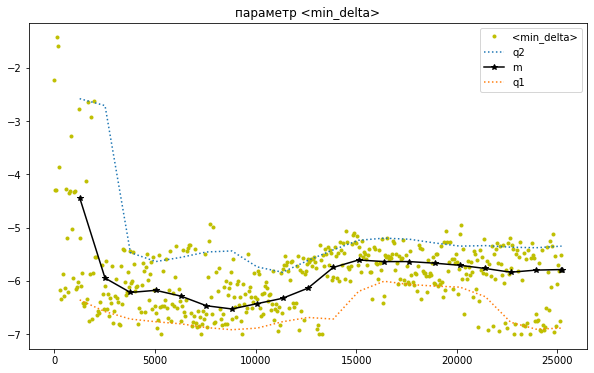

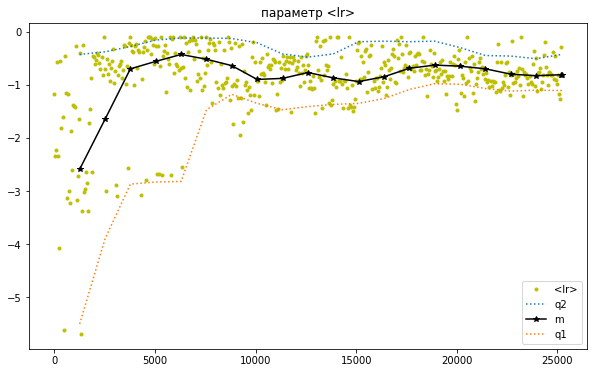

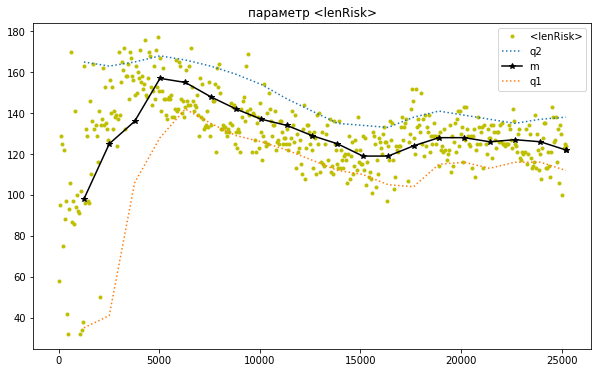

In [8]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','lenRisk'))


## Параметры лучшей

In [9]:
best_par = modelGA.getBestParams()
best_par

{'learnLen': 468,
 'lenRisk': 125,
 'lookback': 111,
 'lr': -0.8400000000001313,
 'min_delta': -5.680000000000028,
 'reg': -2.3100000000001}

# Прогон лучшей

In [10]:
lookback_best = best_par['lookback']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
lenRisk_best = best_par['lenRisk']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(1,offset=1*2+learnLen_best+max(lookback_best,lenRisk_best)+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(1,offset=1*2+learnLen_best+max(lookback_best,lenRisk_best)+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:02:02равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

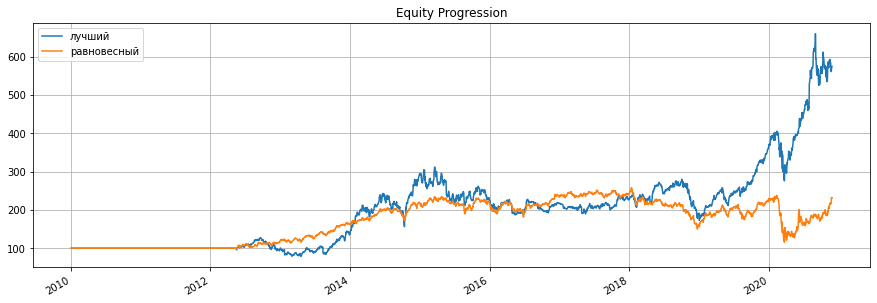

In [11]:
res_best.plot()
plt.grid()

## график распределения долей

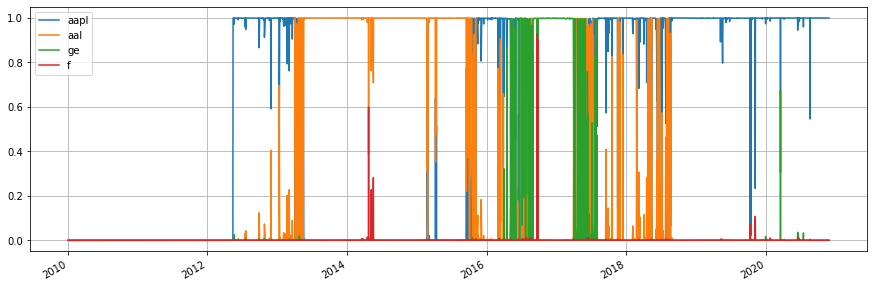

In [12]:

res_best.get_security_weights().plot(figsize=(15,5))
plt.grid()


## график распределения свободной доли

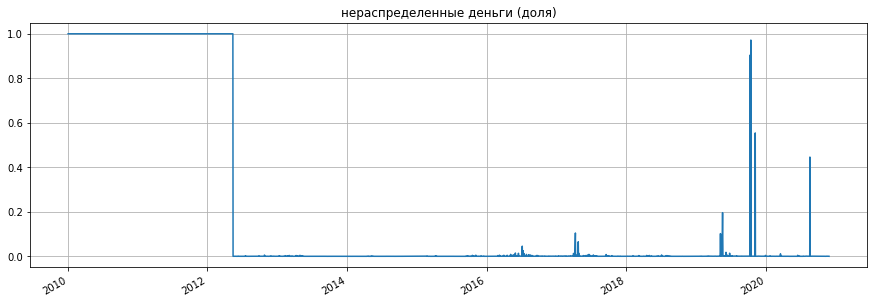

In [13]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot(figsize=(15,5))
plt.grid()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [14]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-11-27  2020-11-27
Risk-free rate       0.00%       0.00%

Total Return         474.11%     130.88%
Daily Sharpe         0.70        0.45
Daily Sortino        1.11        0.71
CAGR                 17.39%      7.98%
Max Drawdown         -44.73%     -55.09%
Calmar Ratio         0.39        0.14

MTD                  7.29%       24.42%
3m                   -6.55%      24.13%
6m                   45.26%      47.63%
YTD                  58.33%      3.53%
1Y                   73.55%      6.07%
3Y (ann.)            34.86%      -0.78%
5Y (ann.)            18.10%      0.65%
10Y (ann.)           19.11%      8.73%
Since Incep. (ann.)  17.39%      7.98%

Daily Sharpe         0.70        0.45
Daily Sortino        1.11        0.71
Daily Mean (ann.)    20.20%      10.35%
Daily Vol (ann.)     28.80%      23.17%
Daily Skew           -0.18      

Енин А.В.

Оренбург